# Exercise: Mandelbrot set

In this excercise, We will be computing the famous [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set). 

The Mandelbrot set is the set of [complex numbers](https://en.wikipedia.org/wiki/Complex_number) $c \in \mathbb{C}$ for which the iteration,

$$z_{n+1} = z_n^2 + c,$$

converges (i.e. does not diverge to infinity), when iterated from $z_0 = 0$. 

The beauty of the Mandelbrot set is that it's [self-similar](https://en.wikipedia.org/wiki/Self-similarity). So if you start to zoom into the set, you may start to see the same pattern showing up again, as you can see in the [gif](https://en.wikipedia.org/wiki/Mandelbrot_set#/media/File:Mandelbrot_sequence_new.gif) of its wikipedia page.

A complex number $c$ belongs to the Mandelbrot set if and only if $ |z_{n}| \le 2 $ for all $ n \ge 0 $ . We can use this property to validate if $c$ is within the Mandelbrot set.

As you may already noticed, we need to investigate infinity number of $c$. And for each $c$, we need to compute infinite number of iterations to validate if it is within the Mandelbrot set. Of course we will not do either of them (hey this is not a mathematics workshop -_^). We will simply:

1. Define a finite extent;
2. Select a finite number of complex numbers within this extent;
3. Validate each complex number with a finite number of iterations. If in any iteration |z_{n}| \ge 2 $, the number is not in the Mandelbrot set. 

In [24]:
# Define a finite extent
CENTER = -0.8 + 0.0j # Location of the extent center
EXTENT_RE = 3.0 # Extent length on the real axis
EXTENT_IM = 3.0 # Extent length on the imaginary axis

# Select finite number of complex numbers
# In total nRE*nIM complex numbers will be inspected 
N_RE = 256 # number of elemtes along the real axis
N_IM = 256 # number of elemtes along the imaginary axis

# Finite iterations
MAX_ITER = 256 # Max number of iterations per

We will start with a native for loop implementation to compute and visualize the Mandelbrot set within a certain extent. 

In [25]:
import numpy as np

def compute_mandelbrot(nIM=N_IM, nRE=N_RE, max_iter=MAX_ITER, center=CENTER, extent_RE=EXTENT_RE, extent_IM=EXTENT_IM):
    niters = np.zeros((nIM, nRE), int)
    scale = max(extent_RE/nRE, extent_IM/nIM)

    # Loop through all selected complex number within the extent
    for j in range(nIM):
        for i in range(nRE):
            c = center + (i - nRE // 2 + (j - nIM //2) * 1j) * scale
            z = 0

            # Per complex number, validate it for a finite number of iterations
            for k in range(max_iter):
                z = z**2 + c

                # if module of the complex number lager than 2,
                # it will diverge, thus not within Mandelbrot set
                if np.absolute(z) > 2.0: 
                    break

            niters[j, i] = k
    return niters

We call the function to compute the iteration numbers per complex number:

In [26]:
niters = compute_mandelbrot()

And we can visualize the interation numbers of all complex numbers we validated:

Text(0, 0.5, '$\\Im(c)$')

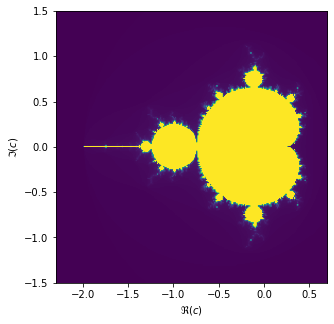

In [27]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_extent = (CENTER.real - EXTENT_RE/2,
               CENTER.real + EXTENT_RE/2,
               CENTER.imag - EXTENT_IM/2,
               CENTER.imag + EXTENT_IM/2)

ax.imshow(niters, origin='lower', extent=plot_extent)
ax.set_xlabel("$\Re(c)$")
ax.set_ylabel("$\Im(c)$")

All the yellow pixels here represents the complex number survived through the max number iterations, thus they are considered as within the Mandelbrot set in our example. So the function seem to be working, but only if we can make it a bit faster...

In [28]:
%timeit compute_mandelbrot()

2.28 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes a few seconds for now to validate all numbers within the given extent. Can you use the parallelization skills you have learnt in this workshop to accelerate the given implementation?

### Solution 1: numba jit

In [29]:
import numba

@numba.jit(nopython=True, nogil=True)
def compute_mandelbrot_numba(nIM=N_IM, nRE=N_RE, max_iter=MAX_ITER, center=CENTER, extent_RE=EXTENT_RE, extent_IM=EXTENT_IM):
    niters = np.zeros((nIM, nRE), np.int64)
    scale = max(extent_RE/nRE, extent_IM/nIM)

    # Loop through all selected complex number within the extent
    for j in range(nIM):
        for i in range(nRE):
            c = center + (i - nRE // 2 + (j - nIM //2) * 1j) * scale
            z = 0

            # Per complex number, validate it for a finite number of iterations
            for k in range(max_iter):
                z = z**2 + c

                # if module of the complex number lager than 2,
                # it will diverge, thus not within Mandelbrot set
                if np.absolute(z) > 2.0: 
                    break

            niters[j, i] = k
    return niters

In [30]:
%timeit compute_mandelbrot_numba()

30.8 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Solution 2: numba jit with parallel

In [31]:
import numba

@numba.jit(nopython=True, parallel=True, nogil=True)
def compute_mandelbrot_numba_parallel(nIM=N_IM, nRE=N_RE, max_iter=MAX_ITER, center=CENTER, extent_RE=EXTENT_RE, extent_IM=EXTENT_IM):
    niters = np.zeros((nIM, nRE), np.int64)
    scale = max(extent_RE/nRE, extent_IM/nIM)

    # Loop through all selected complex number within the extent
    for j in range(nIM):
        for i in range(nRE):
            c = center + (i - nRE // 2 + (j - nIM //2) * 1j) * scale
            z = 0

            # Per complex number, validate it for a finite number of iterations
            for k in range(max_iter):
                z = z**2 + c

                # if modulus (or absolute value) of the complex number is greater than 2,
                # it will diverge, thus not within Mandelbrot set
                if np.absolute(z) > 2.0: 
                    break

            niters[j, i] = k
    return niters

In [32]:
%timeit compute_mandelbrot_numba_parallel()

31.8 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Solution 3: dask bag

In [33]:
import dask.bag as db

@numba.jit(nopython=True, nogil=True)
def iterate_mandelbrot(coords, nIM, nRE, max_iter, center, extent_RE, extent_IM):
    j, i = coords
    z = 0
    scale = max(extent_RE/nRE, extent_IM/nIM)
    c = center + (i - nRE // 2 + (j - nIM //2) * 1j) * scale
    
    # Per complex number, validate it for a finite number of iterations
    for k in range(max_iter):
        z = z**2 + c

        # if module (or absolute value) of the complex number greater than 2,
        # it will diverge, thus not within Mandelbrot set
        if np.absolute(z) > 2.0: 
            break
    return k


def compute_mandelbrot_dask(nIM=N_IM, nRE=N_RE, max_iter=MAX_ITER, center=CENTER, extent_RE=EXTENT_RE, extent_IM=EXTENT_IM):
    initial_state = np.ndindex(nIM, nRE)
    bag = db.from_sequence(initial_state)
    
    return bag.map(lambda x: iterate_mandelbrot(x, nIM, nRE, max_iter, center, extent_RE, extent_IM))


In [34]:
%timeit compute_mandelbrot_dask().compute(scheduler='threads')

2.79 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0, 0.5, '$\\Im(c)$')

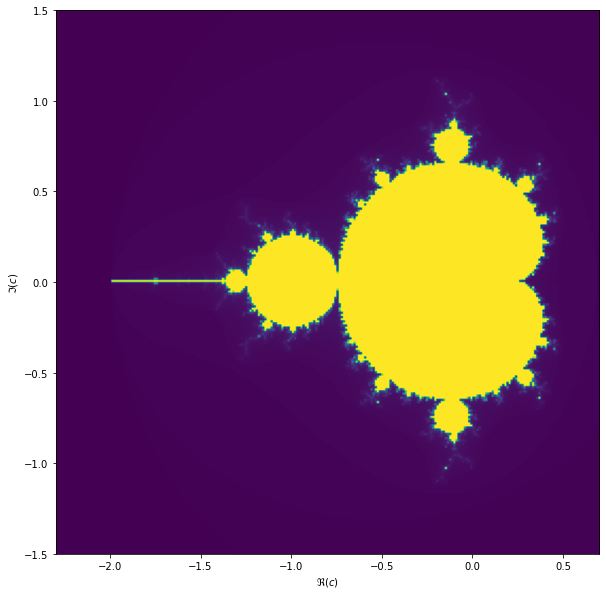

In [35]:
# To visualize this solution, the matrix needs to be reshapen first
result = compute_mandelbrot_dask().compute(scheduler='threads')
niters = np.array(result).reshape((N_IM, N_RE))

fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_extent = (CENTER.real - EXTENT_RE/2,
               CENTER.real + EXTENT_RE/2,
               CENTER.imag - EXTENT_IM/2,
               CENTER.imag + EXTENT_IM/2)

ax.imshow(niters, origin='lower', extent=plot_extent)
ax.set_xlabel("$\Re(c)$")
ax.set_ylabel("$\Im(c)$")

## Extra exercise: Julia set

We have computed the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) in the previous exercise, where we mainly investigated the complex number $c$. Now if we switch our focus from $c$ to $z$, we will be looking into the [Julia set](https://en.wikipedia.org/wiki/Julia_set).

If we look back into the definition of the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) at the begining of this exercise. This time we fix the complex number $c$ as a constant. For this given $c$ value in the iteration

$$z_{n+1} = z_n^2 + c ,$$

all the staring values $z_1$ making this iteration converge are the Julia set of $c$.

As you may notice, this time instead of setting $z_1=0$, we will loop over all the $z_1$ values for a fixed value $c$. The good news is that since the equation for the iteration remains the same, we can still use the same criterion to validate if it converges.

Same as the last exercise we set up a finite searching space:

In [36]:
# Define a finite extent
CENTER = 0.0 + 0.0j # Location of the extent center
EXTENT_RE = 4.0 # Extent length on the real axis
EXTENT_IM = 3.0 # Extent length on the imaginary axis

# Select finite number of complex numbers
# In total nRE*nIM complex numbers will be inspected 
N_RE = 256 # number of elemtes along the real axis
N_IM = 256 # number of elemtes along the imaginary axis

# Finite iterations
MAX_ITER = 256 # Max number of iterations per

# Select a complex number
C = -0.5+0.6j

Then we create a simple loop to search for all the $z_1$ making the iteration converge.

In [37]:
def compute_julia(nIM=N_IM, nRE=N_RE, max_iter=MAX_ITER, center=CENTER, extent_RE=EXTENT_RE, extent_IM=EXTENT_IM, c=C):
    niters = np.zeros((nIM, nRE), int)
    scale = max(extent_RE/nRE, extent_IM/nIM)

    # Loop through all selected complex number within the extent
    for j in range(nIM):
        for i in range(nRE):
            z = center + (i - nRE // 2 + (j - nIM // 2)*1j) * scale

            # Per complex number, validate it for a finite number of iterations
            for k in range(max_iter):
                z = z**2 + c

                # if the modulus (or absolute value) of the complex number is greater than 2,
                # it will diverge, thus not within Mandelbrot set
                if np.absolute(z) > 2.0: 
                    break

            niters[j, i] = k
    return niters

Compute the Julia set for the chosen $c$

In [38]:
niters = compute_julia()

And visualize the result

Text(0, 0.5, '$\\Im(c)$')

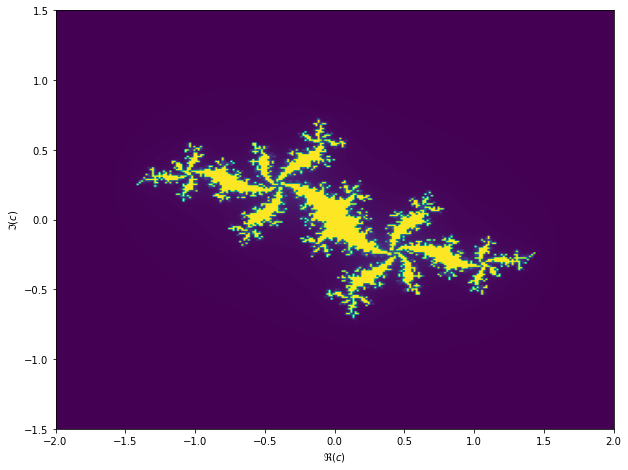

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_extent = (CENTER.real - EXTENT_RE/2,
               CENTER.real + EXTENT_RE/2,
               CENTER.imag - EXTENT_IM/2,
               CENTER.imag + EXTENT_IM/2)

ax.imshow(niters, origin='lower', extent=plot_extent)
ax.set_xlabel("$\Re(c)$")
ax.set_ylabel("$\Im(c)$")

In [40]:
%timeit compute_julia()

952 ms ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So all the bright yellow pixels are considered to be $z_1$ which are wthin the Julia set of $c$. Same as the last exercise, can you make the iteration faster?

### Solution 1: numba jit

In [41]:
import numba

@numba.jit(nopython=True, nogil=True)
def compute_julia_numba(nIM=N_IM, nRE=N_RE, max_iter=MAX_ITER, center=CENTER, extent_RE=EXTENT_RE, extent_IM=EXTENT_IM, c=C):
    niters = np.zeros((nIM, nRE), np.int64)
    scale = max(extent_RE/nRE, extent_IM/nIM)

    # Loop through all selected complex number within the extent
    for j in range(nIM):
        for i in range(nRE):
            z = center + (i - nRE // 2 + (j - nIM // 2)*1j) * scale

            # Per complex number, validate it for a finite number of iterations
            for k in range(max_iter):
                z = z**2 + c

                # if the modulus (or absolute value) of the complex number is greater than 2,
                # it will diverge, thus not within Mandelbrot set
                if np.absolute(z) > 2.0: 
                    break

            niters[j, i] = k
    return niters

In [42]:
%timeit compute_julia_numba()

12.8 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Solution 2: numba jit parallel

In [43]:
import numba

@numba.jit(nopython=True, parallel=True, nogil=True)
def compute_julia_numba_parallel(nIM=N_IM, nRE=N_RE, max_iter=MAX_ITER, center=CENTER, extent_RE=EXTENT_RE, extent_IM=EXTENT_IM, c=C):
    niters = np.zeros((nIM, nRE), np.int64)
    scale = max(extent_RE/nRE, extent_IM/nIM)

    # Loop through all selected complex number within the extent
    for j in range(nIM):
        for i in range(nRE):
            z = center + (i - nRE // 2 + (j - nIM // 2)*1j) * scale

            # Per complex number, validate it for a finite number of iterations
            for k in range(max_iter):
                z = z**2 + c

                # if the modulus (or absolute value) of the complex number is greater than 2,
                # it will diverge, thus not within Mandelbrot set
                if np.absolute(z) > 2.0: 
                    break

            niters[j, i] = k
    return niters

In [44]:
%timeit compute_julia_numba_parallel()

12.8 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Solution 3: Dask bag

In [45]:
import dask.bag as db

@numba.jit(nopython=True, nogil=True)
def iterate_julia(coords, nIM, nRE, max_iter, center, extent_RE, extent_IM,c):
    j, i = coords
    scale = max(extent_RE/nRE, extent_IM/nIM)
    z = center + (i - nRE // 2 + (j - nIM // 2)*1j) * scale
    
    # Per complex number, validate it for a finite number of iterations
    for k in range(max_iter):
        z = z**2 + c

        # if module (or absolute value) of the complex number greater than 2,
        # it will diverge, thus not within Mandelbrot set
        if np.absolute(z) > 2.0: 
            break
    return k


def compute_julia_dask(nIM=N_IM, nRE=N_RE, max_iter=MAX_ITER, center=CENTER, extent_RE=EXTENT_RE, extent_IM=EXTENT_IM, c=C):
    initial_state = np.ndindex(nIM, nRE)
    bag = db.from_sequence(initial_state)
    
    return bag.map(lambda x: iterate_julia(x, nIM, nRE, max_iter, center, extent_RE, extent_IM, c))


In [46]:
%timeit compute_julia_dask().compute(scheduler='threads')

2.83 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0, 0.5, '$\\Im(c)$')

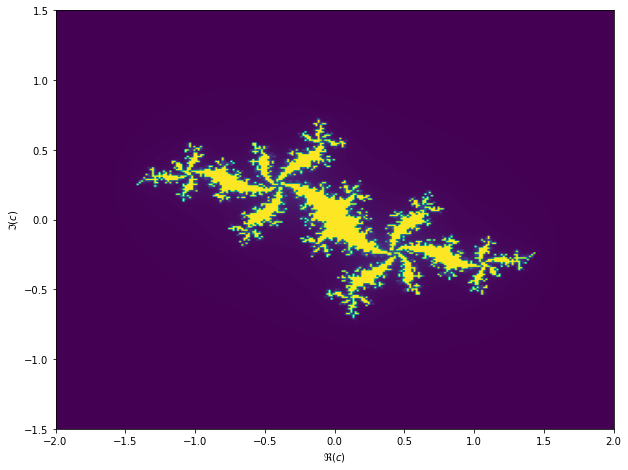

In [47]:
# To visualize this solution, the matrix needs to be reshapen first
result = compute_julia_dask().compute(scheduler='threads')
niters = np.array(result).reshape((N_IM, N_RE))

fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_extent = (CENTER.real - EXTENT_RE/2,
               CENTER.real + EXTENT_RE/2,
               CENTER.imag - EXTENT_IM/2,
               CENTER.imag + EXTENT_IM/2)

ax.imshow(niters, origin='lower', extent=plot_extent)
ax.set_xlabel("$\Re(c)$")
ax.set_ylabel("$\Im(c)$")